In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from db_utils import load_from_db, count_db_entries


In [33]:
train_data = load_from_db(filepath="data/distances_train.db", limit=600000, uniform=True)

In [3]:
test_data = load_from_db(filepath="data/distances_test.db", limit=200000, uniform=True)

In [4]:
count_db_entries(filepath="data/distances_train.db"), count_db_entries(filepath="data/distances_test.db")

(772761, 381868)

In [5]:
class DistanceDataset(Dataset):
    def __init__(self, split="train"):
        self.EPSILON = 1e-8
        self.split = split

        if split == "test":
            self.data = test_data
            return
            
        train_d, val_d = train_test_split(train_data,
                                                test_size=0.2,
                                                random_state=42)
        if split == "val":
            self.data = val_d
        else:
            self.data = train_d
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int, transform: bool = True) -> dict:
        entry = self.data[idx]

        coords, target, timestamps = entry['coordinates'], entry['max_distance'], entry['timestamps']
        if self.split == "train" and transform:
            coords, target = self._transform_coordinates(entry['coordinates'], entry['max_distance'])

        coords_normalized, map_diag = self._normalize_coordinates(coords)
        coords_normalized_tensors = [torch.tensor(c, dtype=torch.float32) for c in coords_normalized]

        times_normalized, _, _ = self._normalize_timestamps(timestamps)
        times_normalized_tensors = [torch.tensor(ts, dtype=torch.float32).unsqueeze(-1) for ts in times_normalized]

        target_normalized = torch.tensor(target / (map_diag + self.EPSILON), dtype=torch.float32)

        points_normalized = [torch.hstack((c, ts)) for c, ts in zip(coords_normalized_tensors, times_normalized_tensors)]

        return {
            "points": points_normalized,
            "target": target_normalized,
            "map_diag": torch.tensor(map_diag, dtype=torch.float32)
        }
    
    def _normalize_coordinates(self, coordinates: list) -> np.ndarray:
        coords_flat = np.array([c for coords in coordinates for c in coords])
        max_vals = coords_flat.max(axis=0)
        min_vals = coords_flat.min(axis=0)
        map_diag = np.linalg.norm(max_vals - min_vals)
        center = (max_vals + min_vals) / 2
        coords_normalized = []
        for coords in coordinates:
            coords_normalized.append((coords - center) / (map_diag + self.EPSILON))
        return coords_normalized, map_diag
    
    def _normalize_timestamps(self, timestamps: list) -> np.ndarray:
        times_flat = np.array([ts for times in timestamps for ts in times])
        t_max = times_flat.max()
        t_min = times_flat.min()
        times_normalized = []
        for ts in timestamps:
            times_normalized.append((ts - t_min) / (t_max - t_min + self.EPSILON))
        return times_normalized, t_max, t_min

    def _transform_coordinates(self, coordinates: list, target: float) -> np.ndarray:
        scaling_factor = np.random.uniform(0.5, 10.0)
        coords_augmented = []
        for coords in coordinates:
            coords_augmented.append(coords * scaling_factor)
        return coords_augmented, target * scaling_factor


In [6]:
def collate_fn(batch) -> dict:
    targets = torch.stack([item['target'] for item in batch])
    map_diag = torch.stack([item['map_diag'] for item in batch])

    lengths = []
    points = []
    instance_ids = []
    for id, item in enumerate(batch):
        points.extend(item['points'])
        lengths.extend([len(path) for path in item['points']])
        instance_ids.extend([id] * len(item['points']))

    lengths = torch.tensor(lengths)
    instance_ids = torch.tensor(instance_ids)

    padded = nn.utils.rnn.pad_sequence(points, batch_first=True)

    return {
        "points": padded,
        "lengths": lengths,
        "instance_ids": instance_ids,
        "target": targets,
        "map_diag": map_diag
    }

In [35]:
train_dataset = DistanceDataset(split="train")
val_dataset = DistanceDataset(split="val")
test_dataset = DistanceDataset(split="test")

In [32]:
print(f"Train dataset len: {len(train_dataset)}, Val dataset len: {len(val_dataset)}, Test dataset len: {len(test_dataset)}")

Train dataset len: 480000, Val dataset len: 120000, Test dataset len: 200000


In [9]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

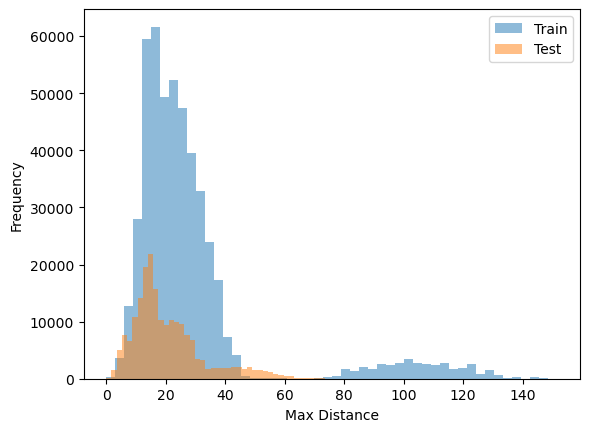

: 

In [ ]:
# Plot target values distribution for test dataset and train dataset
plt.hist([entry['max_distance'] for entry in train_dataset.data], bins=50, alpha=0.5, label='Train')
plt.hist([entry['max_distance'] for entry in test_dataset.data], bins=50, alpha=0.5, label='Test')
plt.xlabel('Max Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
class PathEncoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2)
    
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h_n, _) = self.lstm(packed)
        ordered_h_n = h_n.index_select(1, packed.unsorted_indices)
        return ordered_h_n[-1]

In [13]:
class InteractionModule(nn.Module):
    def __init__(self, hidden_dim=64, nhead=4, nlayers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.hidden_dim = hidden_dim

    def forward(self, agents_embs, ids):
        unique_ids, idx = ids.unique(return_inverse=True)
        num_groups = unique_ids.shape[0]
        group_sizes = torch.bincount(idx)
        max_group_size = group_sizes.max()

        group_embs = torch.zeros(num_groups, max_group_size, self.hidden_dim, device=agents_embs.device)
        padding_mask = torch.ones(num_groups, max_group_size, dtype=torch.bool, 
                            device=agents_embs.device)

        for group_idx, group_id in enumerate(unique_ids):
            mask = (ids == group_id)
            group_agents = agents_embs[mask]  # [num_agents_in_group, hidden_dim]
            num_agents = group_agents.size(0)
            group_embs[group_idx, :num_agents] = group_agents
            padding_mask[group_idx, :num_agents] = False

        # group_embs: [num_groups, max_group_size, hidden_dim]
        # padding_mask: [num_groups, max_group_size]
        transformer_output = self.transformer(group_embs, src_key_padding_mask=padding_mask)
        
        masked_output = transformer_output * (~padding_mask).unsqueeze(-1).float()
        valid_lengths = (~padding_mask).sum(dim=1, keepdim=True).float()  
        pooled_outputs = masked_output.sum(dim=1) / torch.clamp(valid_lengths, min=1.0)
        return pooled_outputs

In [14]:
class PredictionHead(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        return self.fc(x).squeeze(1)

In [15]:
class Model(nn.Module):
    def __init__(self, hidden_dim=128, device=device):
        super().__init__()
        self.path_encoder = PathEncoder(hidden_dim=hidden_dim)
        self.interaction_module = InteractionModule(hidden_dim=hidden_dim)
        self.prediction_head = PredictionHead(hidden_dim=hidden_dim)
        self.device = device

    def forward(self, batch):
        points = batch['points'].to(self.device)
        lengths = batch['lengths'].to(self.device)
        instance_ids = batch['instance_ids'].to(self.device)

        path_embs = self.path_encoder(points, lengths)
        interacted_embs = self.interaction_module(path_embs, instance_ids)
        predictions = self.prediction_head(interacted_embs)
        return predictions

In [16]:
class Gym:
    def __init__(self, model, train_loader, test_loader, lr=1e-3):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        for batch in tqdm(self.train_loader):
            predictions = self.model(batch)
            loss = self.criterion(predictions, batch['target'].to(self.model.device))

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * len(batch['target'])
        return total_loss / len(self.train_loader.dataset)

    def evaluate(self):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in tqdm(self.test_loader):
                predictions = self.model(batch)
                loss = self.criterion(predictions, batch['target'].to(self.model.device))
                total_loss += loss.item() * len(batch['target'])
        return total_loss / len(self.test_loader.dataset)

In [19]:
gym = Gym(
    model=Model().to(device),
    train_loader=train_loader,
    test_loader=val_loader,
    lr=1e-3
)

In [20]:
def train():
    losses = []
    patience = 5
    best_val_loss = float("inf")

    for epoch in range(100):
        train_loss = gym.train_epoch()
        val_loss = gym.evaluate()
        losses.append((train_loss, val_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(gym.model.state_dict(), 'checkpoints/model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    return losses
losses = train()

  0%|          | 0/7500 [00:00<?, ?it/s]/home/marcotuliopin/miniconda3/envs/argus/lib/python3.13/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1739474893324/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
100%|██████████| 7500/7500 [01:55<00:00, 64.66it/s]


Epoch 1, Train Loss: 0.0203, Val Loss: 0.0206


100%|██████████| 7500/7500 [01:47<00:00, 69.91it/s]


Epoch 2, Train Loss: 0.0201, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:46<00:00, 70.10it/s]


Epoch 3, Train Loss: 0.0201, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:54<00:00, 65.75it/s]


Epoch 4, Train Loss: 0.0201, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:48<00:00, 69.14it/s]


Epoch 5, Train Loss: 0.0201, Val Loss: 0.0202


100%|██████████| 7500/7500 [01:51<00:00, 67.40it/s]


Epoch 6, Train Loss: 0.0201, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:47<00:00, 69.83it/s]


Epoch 7, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:49<00:00, 68.71it/s]


Epoch 8, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:49<00:00, 68.30it/s]


Epoch 9, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:50<00:00, 68.05it/s]


Epoch 10, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:50<00:00, 68.03it/s]


Epoch 11, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:48<00:00, 68.96it/s]


Epoch 12, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:49<00:00, 68.75it/s]


Epoch 13, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:46<00:00, 70.63it/s]


Epoch 14, Train Loss: 0.0200, Val Loss: 0.0201


100%|██████████| 7500/7500 [01:49<00:00, 68.47it/s]

Early stopping triggered


In [29]:
# Create test dataset and loader

print(f"Test dataset size: {len(test_dataset)}")
print(f"Test loader batches: {len(test_loader)}")

Test dataset size: 200000
Test loader batches: 12500


In [21]:
test_model = Model().to(device)
test_model.load_state_dict(torch.load('checkpoints/model.pth', map_location=device))
test_model.eval()

Model(
  (path_encoder): PathEncoder(
    (lstm): LSTM(3, 128, num_layers=2, batch_first=True)
  )
  (interaction_module): InteractionModule(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (prediction_head): PredictionHead(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=256,

In [22]:
# Make predictions on test set
predictions = []
true_values = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        batch_map_diag = batch['map_diag'].to(test_model.device)
        batch_predictions = test_model(batch) * batch_map_diag
        batch_targets = batch['target'].to(test_model.device) * batch_map_diag

        predictions.extend(batch_predictions.cpu().numpy())
        true_values.extend(batch_targets.cpu().numpy())

predictions = np.array(predictions)
true_values = np.array(true_values)

print(f"Made predictions for {len(predictions)} test samples")

Testing: 100%|██████████| 12500/12500 [03:52<00:00, 53.80it/s]


Made predictions for 200000 test samples


In [27]:
# Calculate evaluation metrics
mae = mean_absolute_error(true_values, predictions)
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predictions)

print("=== Test Results ===")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print()

# Additional statistics
print("=== Data Statistics ===")
print(f"True values - Mean: {np.mean(true_values):.4f}, Std: {np.std(true_values):.4f}")
print(f"Predictions - Mean: {np.mean(predictions):.4f}, Std: {np.std(predictions):.4f}")
print(f"True values range: [{np.min(true_values):.4f}, {np.max(true_values):.4f}]")
print(f"Predictions range: [{np.min(predictions):.4f}, {np.max(predictions):.4f}]")

=== Test Results ===
Mean Absolute Error (MAE): 3.1027
Mean Squared Error (MSE): 20.5835
Root Mean Squared Error (RMSE): 4.5369
R² Score: 0.8624

=== Data Statistics ===
True values - Mean: 20.7100, Std: 12.2298
Predictions - Mean: 21.8188, Std: 12.6537
True values range: [0.0000, 87.6926]
Predictions range: [0.0000, 68.3217]


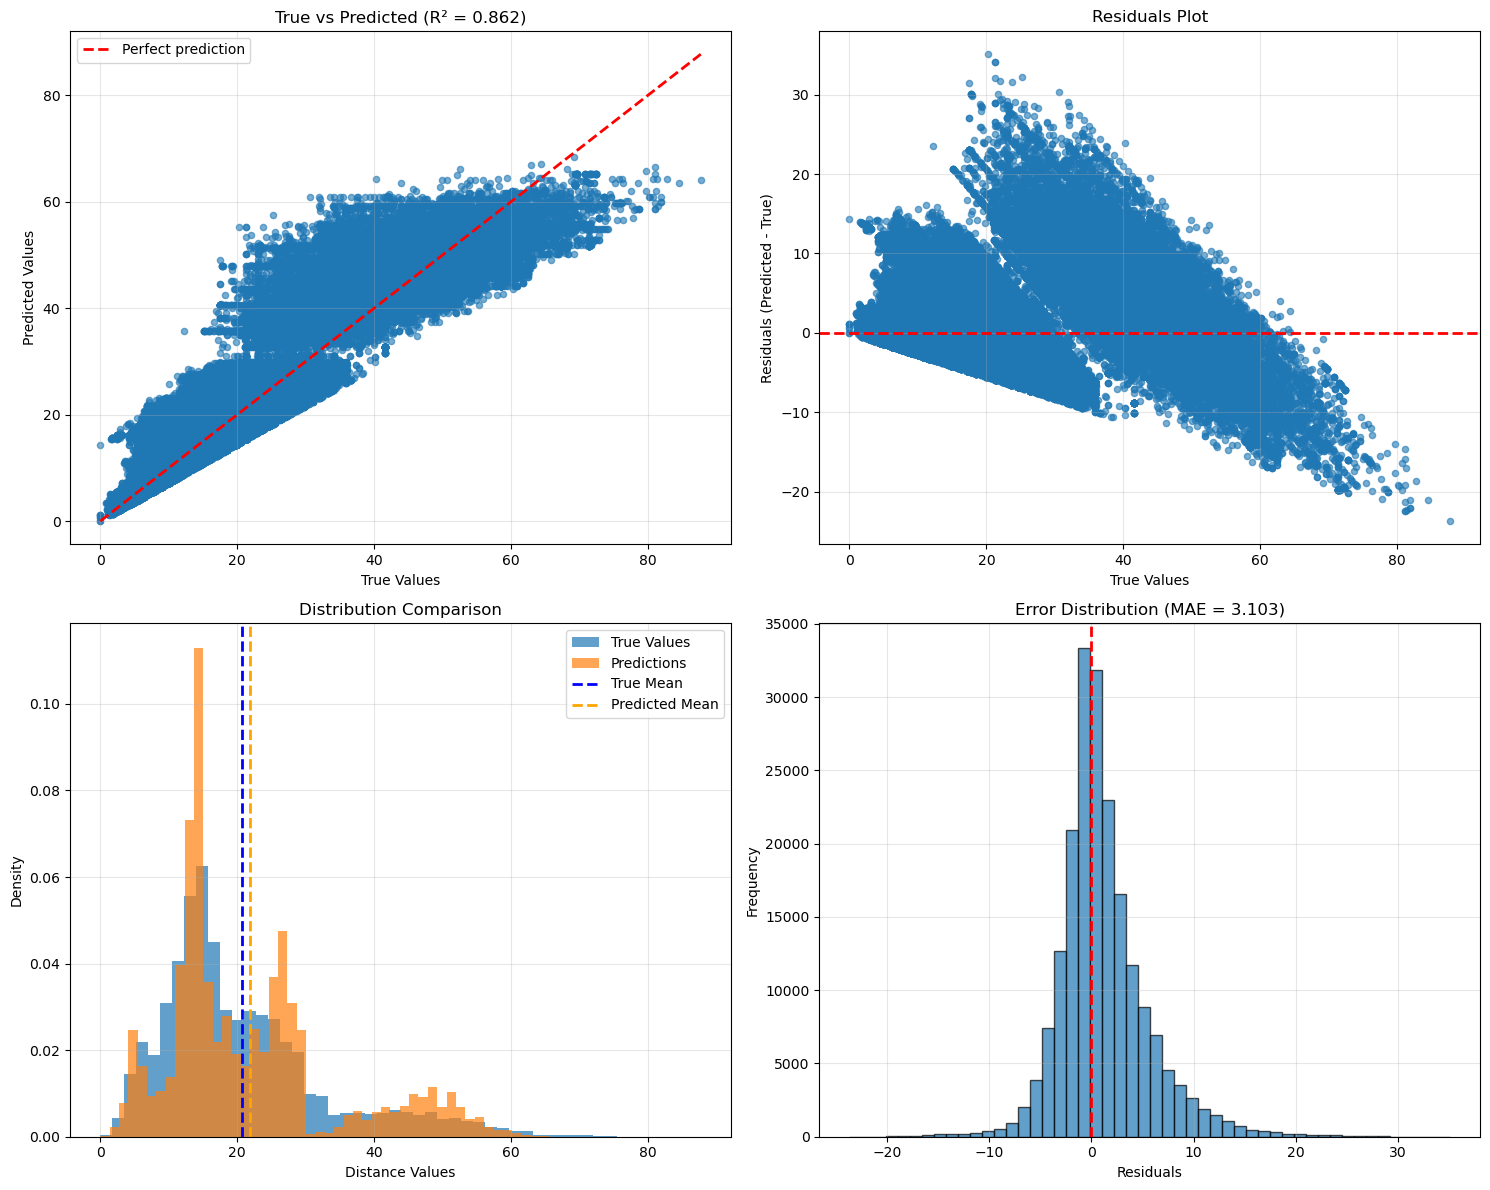

In [28]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: True vs Predicted
axes[0, 0].scatter(true_values, predictions, alpha=0.6, s=20)
axes[0, 0].plot([true_values.min(), true_values.max()], 
                [true_values.min(), true_values.max()], 'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'True vs Predicted (R² = {r2:.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = predictions - true_values
axes[0, 1].scatter(true_values, residuals, alpha=0.6, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('True Values')
axes[0, 1].set_ylabel('Residuals (Predicted - True)')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution comparison
axes[1, 0].hist(true_values, bins=50, alpha=0.7, label='True Values', density=True)
axes[1, 0].hist(predictions, bins=50, alpha=0.7, label='Predictions', density=True)
true_mean = np.mean(true_values)
pred_mean = np.mean(predictions)
axes[1, 0].axvline(x=true_mean, color='b', linestyle='--', lw=2, label='True Mean')
axes[1, 0].axvline(x=pred_mean, color='orange', linestyle='--', lw=2, label='Predicted Mean')
axes[1, 0].set_xlabel('Distance Values')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distribution Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Error distribution
axes[1, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Error Distribution (MAE = {mae:.3f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Ranking/Order Correlation Analysis
from scipy.stats import spearmanr, kendalltau, pearsonr
from scipy.spatial.distance import cdist

def calculate_ranking_metrics(true_vals, pred_vals):
    """Calculate various ranking correlation metrics."""
    print("=== Ranking Correlation Analysis ===")
    
    # 1. Spearman Rank Correlation (most common for ranking)
    spearman_corr, spearman_p = spearmanr(true_vals, pred_vals)
    print(f"Spearman Rank Correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")
    
    # 2. Kendall's Tau (robust to outliers)
    kendall_corr, kendall_p = kendalltau(true_vals, pred_vals)
    print(f"Kendall's Tau: {kendall_corr:.4f} (p-value: {kendall_p:.2e})")
    
    # 3. Pearson for comparison (linear correlation)
    pearson_corr, pearson_p = pearsonr(true_vals, pred_vals)
    print(f"Pearson Correlation: {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
    print()
    
    # 4. Top-K ranking accuracy
    print("=== Top-K Ranking Accuracy ===")
    n = len(true_vals)
    for k in [5, 10, 20, 50]:
        if k >= n:
            continue
        
        # Get top-k indices for true and predicted values
        true_top_k = np.argsort(true_vals)[-k:]  # highest k values
        pred_top_k = np.argsort(pred_vals)[-k:]
        
        # Calculate intersection
        intersection = len(set(true_top_k) & set(pred_top_k))
        accuracy = intersection / k
        
        print(f"Top-{k} accuracy: {accuracy:.3f} ({intersection}/{k} correct)")
    
    print()
    
    # 5. Ranking difference analysis
    true_ranks = np.argsort(np.argsort(true_vals))  # ranks from 0 to n-1
    pred_ranks = np.argsort(np.argsort(pred_vals))
    
    rank_diff = np.abs(true_ranks - pred_ranks)
    print("=== Ranking Difference Analysis ===")
    print(f"Mean absolute rank difference: {np.mean(rank_diff):.2f}")
    print(f"Median absolute rank difference: {np.median(rank_diff):.2f}")
    print(f"Max rank difference: {np.max(rank_diff)}")
    print(f"Std rank difference: {np.std(rank_diff):.2f}")
    
    # Percentage of samples with small rank differences
    for threshold in [1, 5, 10, 20]:
        pct = np.mean(rank_diff <= threshold) * 100
        print(f"Samples within {threshold} ranks: {pct:.1f}%")
    
    print()
    
    # 6. Normalized Discounted Cumulative Gain (NDCG) - for ranking quality
    def dcg_at_k(relevance_scores, k):
        """Calculate DCG@k"""
        relevance_scores = relevance_scores[:k]
        gains = 2**relevance_scores - 1
        discounts = np.log2(np.arange(2, len(relevance_scores) + 2))
        return np.sum(gains / discounts)
    
    # Use true values as relevance scores, sort by predicted values
    sorted_indices = np.argsort(pred_vals)[::-1]  # descending order
    relevance_scores = true_vals[sorted_indices]
    
    # Calculate NDCG for different k values
    print("=== NDCG (Normalized Discounted Cumulative Gain) ===")
    for k in [5, 10, 20, 50]:
        if k >= n:
            continue
        
        # DCG with predicted ranking
        dcg = dcg_at_k(relevance_scores, k)
        
        # Ideal DCG (perfect ranking)
        ideal_relevance = np.sort(true_vals)[::-1]  # descending order
        idcg = dcg_at_k(ideal_relevance, k)
        
        # NDCG
        ndcg = dcg / idcg if idcg > 0 else 0
        print(f"NDCG@{k}: {ndcg:.4f}")
    
    return {
        'spearman': spearman_corr,
        'kendall': kendall_corr,
        'pearson': pearson_corr,
        'mean_rank_diff': np.mean(rank_diff),
        'median_rank_diff': np.median(rank_diff)
    }

# Calculate ranking metrics
ranking_results = calculate_ranking_metrics(true_values, predictions)

=== Ranking Correlation Analysis ===
Spearman Rank Correlation: 0.9245 (p-value: 0.00e+00)
Kendall's Tau: 0.7737 (p-value: 0.00e+00)
Pearson Correlation: 0.9380 (p-value: 0.00e+00)

=== Top-K Ranking Accuracy ===
Top-5 accuracy: 0.000 (0/5 correct)
Top-10 accuracy: 0.000 (0/10 correct)
Top-20 accuracy: 0.100 (2/20 correct)
Top-50 accuracy: 0.080 (4/50 correct)

=== Ranking Difference Analysis ===
Mean absolute rank difference: 16212.77
Median absolute rank difference: 11319.50
Max rank difference: 124312
Std rank difference: 15669.31
Samples within 1 ranks: 0.0%
Samples within 5 ranks: 0.0%
Samples within 10 ranks: 0.1%
Samples within 20 ranks: 0.2%

=== NDCG (Normalized Discounted Cumulative Gain) ===
NDCG@5: 0.0039
NDCG@10: 0.0051
NDCG@20: 0.0050
NDCG@50: 0.0086


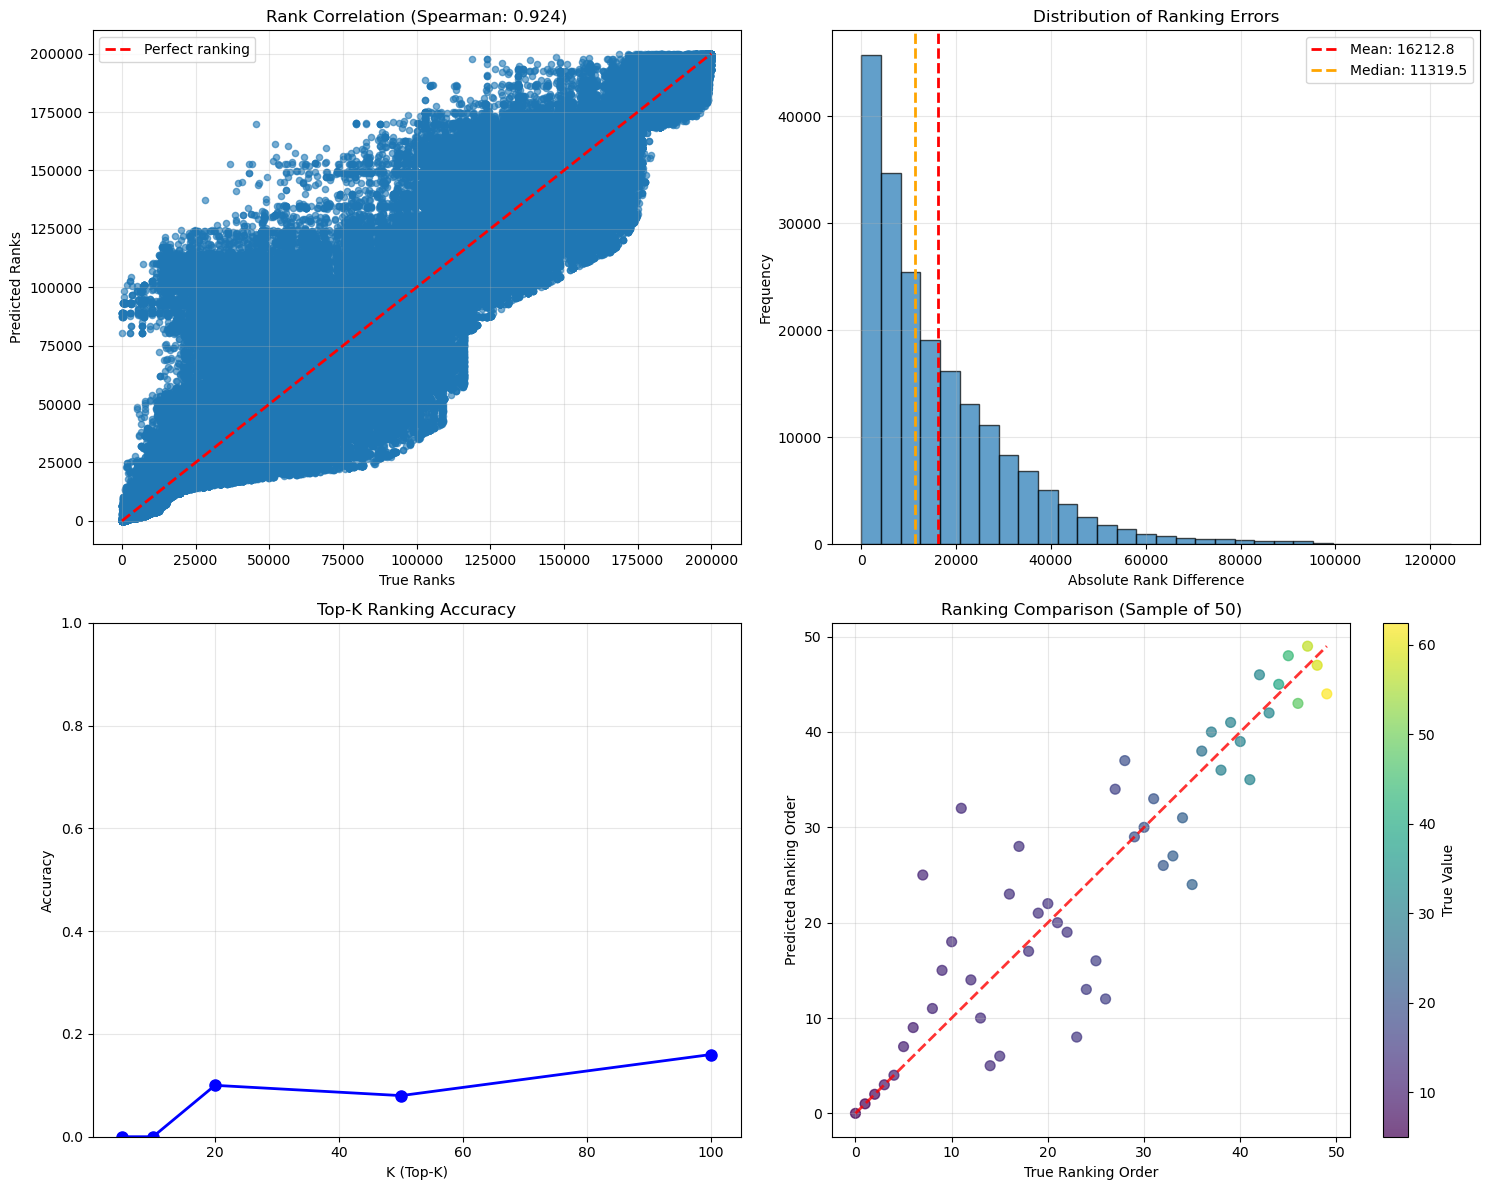


=== RANKING SUMMARY ===
🎯 Spearman Correlation: 0.9245 (Excellent)
🎯 Kendall's Tau: 0.7737
📊 Mean Rank Error: 16212.8 positions
📊 Median Rank Error: 11319.5 positions
✅ EXCELLENT ranking quality - Model preserves order very well!


In [26]:
# Visual Analysis of Ranking Quality
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Rank correlation scatter plot
true_ranks = np.argsort(np.argsort(true_values))  # ranks from 0 to n-1
pred_ranks = np.argsort(np.argsort(predictions))

axes[0, 0].scatter(true_ranks, pred_ranks, alpha=0.6, s=20)
axes[0, 0].plot([0, len(true_values)-1], [0, len(true_values)-1], 'r--', lw=2, label='Perfect ranking')
axes[0, 0].set_xlabel('True Ranks')
axes[0, 0].set_ylabel('Predicted Ranks')
axes[0, 0].set_title(f'Rank Correlation (Spearman: {ranking_results["spearman"]:.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Rank difference distribution
rank_diff = np.abs(true_ranks - pred_ranks)
axes[0, 1].hist(rank_diff, bins=30, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=np.mean(rank_diff), color='r', linestyle='--', lw=2, label=f'Mean: {np.mean(rank_diff):.1f}')
axes[0, 1].axvline(x=np.median(rank_diff), color='orange', linestyle='--', lw=2, label=f'Median: {np.median(rank_diff):.1f}')
axes[0, 1].set_xlabel('Absolute Rank Difference')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Ranking Errors')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Top-K accuracy visualization
k_values = [5, 10, 20, 50, 100]
top_k_accuracies = []

for k in k_values:
    if k >= len(true_values):
        top_k_accuracies.append(np.nan)
        continue
    
    true_top_k = set(np.argsort(true_values)[-k:])
    pred_top_k = set(np.argsort(predictions)[-k:])
    intersection = len(true_top_k & pred_top_k)
    accuracy = intersection / k
    top_k_accuracies.append(accuracy)

valid_mask = ~np.isnan(top_k_accuracies)
axes[1, 0].plot(np.array(k_values)[valid_mask], np.array(top_k_accuracies)[valid_mask], 'bo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('K (Top-K)')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Top-K Ranking Accuracy')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# 4. Ranking quality heatmap (sample)
# Show a small sample of ranking quality
sample_size = min(50, len(true_values))
sample_indices = np.random.choice(len(true_values), sample_size, replace=False)

sample_true = true_values[sample_indices]
sample_pred = predictions[sample_indices]

# Sort by true values for visualization
sort_idx = np.argsort(sample_true)
sample_true_sorted = sample_true[sort_idx]
sample_pred_sorted = sample_pred[sort_idx]

# Create ranking matrix
x_pos = np.arange(sample_size)
true_order = np.arange(sample_size)
pred_order = np.argsort(np.argsort(sample_pred_sorted))

# Create a scatter plot showing the ranking
axes[1, 1].scatter(true_order, pred_order, c=sample_true_sorted, cmap='viridis', s=50, alpha=0.7)
axes[1, 1].plot([0, sample_size-1], [0, sample_size-1], 'r--', lw=2, alpha=0.8)
axes[1, 1].set_xlabel('True Ranking Order')
axes[1, 1].set_ylabel('Predicted Ranking Order')
axes[1, 1].set_title(f'Ranking Comparison (Sample of {sample_size})')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('True Value')

plt.tight_layout()
plt.show()

# Summary of ranking performance
print(f"\n=== RANKING SUMMARY ===")
print(f"🎯 Spearman Correlation: {ranking_results['spearman']:.4f} ({'Excellent' if ranking_results['spearman'] > 0.9 else 'Good' if ranking_results['spearman'] > 0.7 else 'Fair' if ranking_results['spearman'] > 0.5 else 'Poor'})")
print(f"🎯 Kendall's Tau: {ranking_results['kendall']:.4f}")
print(f"📊 Mean Rank Error: {ranking_results['mean_rank_diff']:.1f} positions")
print(f"📊 Median Rank Error: {ranking_results['median_rank_diff']:.1f} positions")

if ranking_results['spearman'] > 0.8:
    print("✅ EXCELLENT ranking quality - Model preserves order very well!")
elif ranking_results['spearman'] > 0.6:
    print("✅ GOOD ranking quality - Model captures most of the ordering")
elif ranking_results['spearman'] > 0.4:
    print("⚠️  FAIR ranking quality - Some ordering preserved but significant errors")
else:
    print("❌ POOR ranking quality - Model fails to capture ordering")